# Traffic light detection
## Phase 2: Create data-set for traffic light detection
### Members of the team: Avigail Wilk, Hadass Wittow and Nechama Verbov
### Credits:
* https://docs.scipy.org/doc/numpy/reference/generated/numpy.memmap.html

In [1]:
import json
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob
import random
from scipy import ndimage
import scipy.ndimage.filters as filters
import numpy as np

### Importing data

In [2]:
#Database location on Disk
gt_dir = r'gtFine'
imgs_dir = r'leftImg8bit'

gt_train_path = os.path.join(gt_dir, 'train')
imgs_train_path = os.path.join(imgs_dir, 'train')
gt_val_path = os.path.join(gt_dir, 'val')
imgs_val_path = os.path.join(imgs_dir, 'val')

def get_files(imgs_dir, gt_dir):
    
    cities = os.listdir(imgs_dir)
    gt = []
    imgs = []
    for city in cities:
        new_gt_path = os.path.join(gt_dir, city)
        new_imgs_path = os.path.join(imgs_dir, city)
        gt += glob.glob(os.path.join(new_gt_path, "*color.png"))
        imgs += glob.glob(os.path.join(new_imgs_path, "*.png"))
    imgs.sort()
    gt.sort()
    return imgs, gt

train_imgs, train_gt = get_files(imgs_train_path, gt_train_path)
val_imgs, val_gt = get_files(imgs_val_path, gt_val_path)

### Creating directory for traffic light training and validation data-set

In [3]:
if not os.path.exists("data_dir"):
    os.mkdir('data_dir')
    os.mkdir("data_dir/train")
    os.mkdir("data_dir/val")

### Cropping image to fit area of traffic light or area with no traffic light

In [4]:
def crop_pic(mat, y, x):
    if x-40 < 0 or y-40 < 0 or x+41 > mat.shape[1] or y + 41 > mat.shape[0]:
        return None

    c =  mat[y - 40 : y + 41, x - 40 : x + 41, 0:3]

    return c

### Finds pixels with traffic light and pixels without according to candidates from a light source filter

In [5]:
def true_and_false_pixels(img_set, true_set):
    positive_pixels = [] 
    negative_pixels = []
   
    false_pixels = np.where((true_set == False) & (img_set==True))
    true_pixels = np.where(true_set == True)

    false_pixels = set(zip(false_pixels[0], false_pixels[1]))
    true_pixels = set(zip(true_pixels[0], true_pixels[1]))
    
    if len(true_pixels) >= 4 and len(false_pixels) >= 4:
        positive_pixels = random.choices(tuple(true_pixels), k=4)
        negative_pixels = random.choices(tuple(false_pixels), k=4)

   
    return  positive_pixels, negative_pixels

### Light source filter: returns mask of pixels that are suspected of being a traffic light

In [6]:
def hpf_red(img):
    kernel = np.array([[-1/9]*3, [-1/9, 8/9, -1/9], [-1/9]*3])
    hpf_arr = ndimage.convolve(img[:,:,0], kernel) 

    return hpf_arr
def local_max(data):
    return filters.maximum_filter(data, size = 21)

In [7]:
def get_suspect_set(img):
    red_filtered_img = hpf_red(img)
    red_max_img = local_max(red_filtered_img)
    return red_max_img > img[:,:,0]
    

### Returns mask of traffic light pixels in a labeled image

In [8]:
def find_colored_pixels(img):
    mask = ((img[:,:,0]==250/255) & (img[:,:,1]==170/255) & (img[:,:,2]==30/255))
    return mask


### Iterates over images to create a unique dataset for traffic light detection

In [9]:
def iterate_imgs(data_file, label_file, imgs, train_gt):
    with open(data_file, "wb") as  data, open(label_file, "wb") as labels:
        label_list = []
        index = 0
            
        for idx, img in enumerate(imgs):

            img = plt.imread(img)
            gt_img = plt.imread(train_gt[idx])
            
            img_set = get_suspect_set(img)
            img_labels = find_colored_pixels(gt_img)
                
            if(np.any(img_labels) and len(img_set) > 3):
                
  
                true_list, false_list = true_and_false_pixels(img_set, img_labels)

                if len(true_list):

                    for i in range(4):
                            cropped = crop_pic(img, *true_list[i])
                            if cropped is not None:

                                assert cropped.shape == (81,81,3)

                                ((cropped * 255).astype(np.uint8)).tofile(data)
                                label_list.append(1)

                            cropped = crop_pic(img, *false_list[i])
                            if cropped is not None:

                                assert cropped.shape == (81,81,3)

                                ((cropped * 255).astype(np.uint8)).tofile(data)
                                label_list.append(0)

        np.array(label_list, dtype=np.uint8).tofile(labels)

In [10]:
iterate_imgs("data_dir/train/data.bin", "data_dir/train/labels.bin", train_imgs, train_gt)

In [11]:
iterate_imgs("data_dir/val/data.bin", "data_dir/val/labels.bin", val_imgs, val_gt)

### Adding images to the dataset by augmentation

In [ ]:
def data_augmentation(dir_name):
    data_dir_path = 'data_dir/'+ dir_name+'/data.bin'
    label_dir_path='data_dir/'+ dir_name+'/labels.bin'
    
    image_size=81*81*3
    image_num = int(os.path.getsize(data_dir_path)/image_size)
    
    with open(data_dir_path, 'ab+') as data_file, open(label_dir_path,'ab+') as label_file:
        for idx in range(image_num):
            data = np.memmap(data_file,  dtype='uint8', mode='r', shape=(81,81,3), offset = image_size*idx)
            label = np.memmap(label_file,  dtype='uint8', mode='r', shape=(1,), offset = idx)
            fliped_image=data[:,::-1]
            fliped_image.tofile(data_file)
            label.tofile(label_file)

In [ ]:
data_augmentation("train")

### Showing a few images from training data-set

In [20]:
def show_train_dataset(fname, amount):
    data = np.memmap(fname, dtype=np.uint8,shape=(amount,81,81,3)) 
    return data
       
data = show_train_dataset(r'data_dir/train/data.bin', 22224)

In [21]:
def show_train_labels(gname, amount):
    labels = np.memmap(gname, dtype=np.uint8, shape = amount)
    return labels

labels = show_train_labels(r'data_dir/train/labels.bin', 22224)

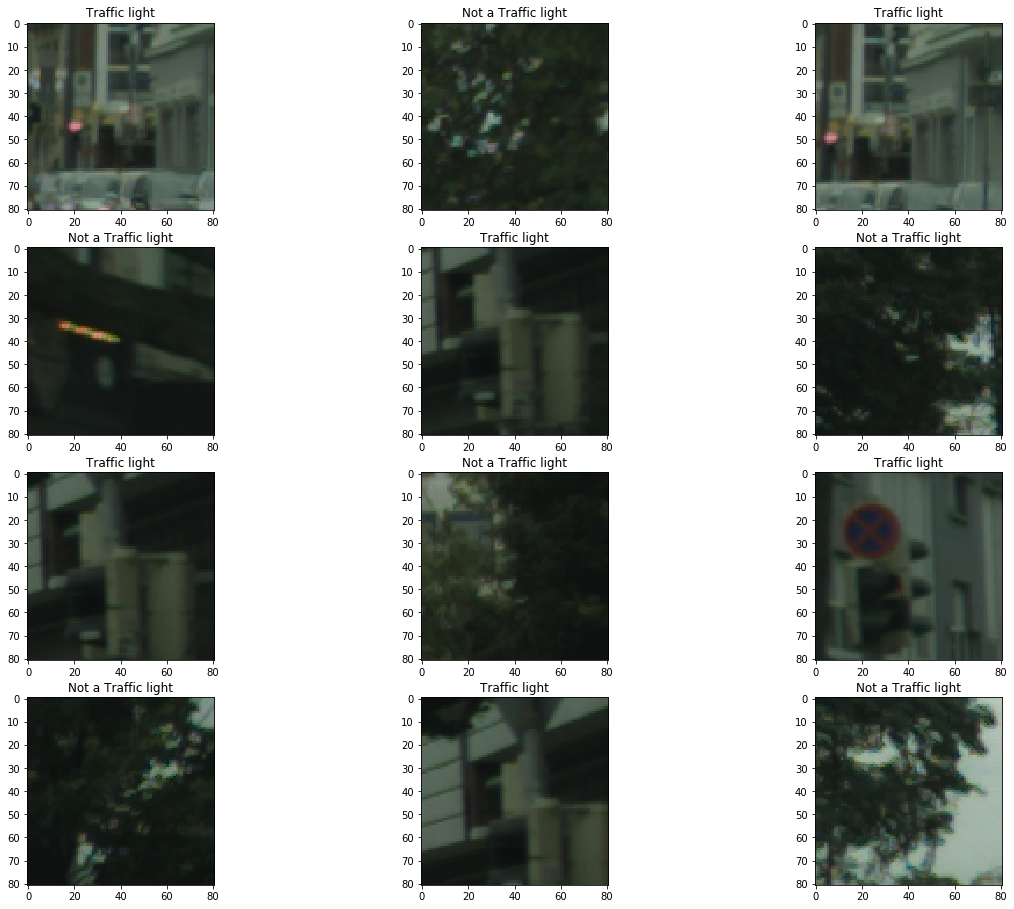

In [22]:
fig = plt.figure(figsize=(20,20))
 
j=0
rand=random.randint(0, 22212)

for i in range(rand, rand + 12):
    a = fig.add_subplot(5,3,j+1)
    j+=1
    a.imshow(data[i])
    a.title.set_text("Traffic light" if labels[i] else "Not a Traffic light");
    
plt.show()

### Showing a few images from validation data-set

In [23]:
def show_val_dataset(fname, amount):
    data = np.memmap(fname, dtype=np.uint8,shape=(amount,81,81,3)) 
    return data
   
        
data = show_val_dataset(r'data_dir/val/data.bin', 1821)

In [24]:
def show_val_labels(gname, amount):
    labels = np.memmap(gname, dtype=np.uint8, shape = amount)
    return labels

labels = show_val_labels(r'data_dir/val/labels.bin', 1821)

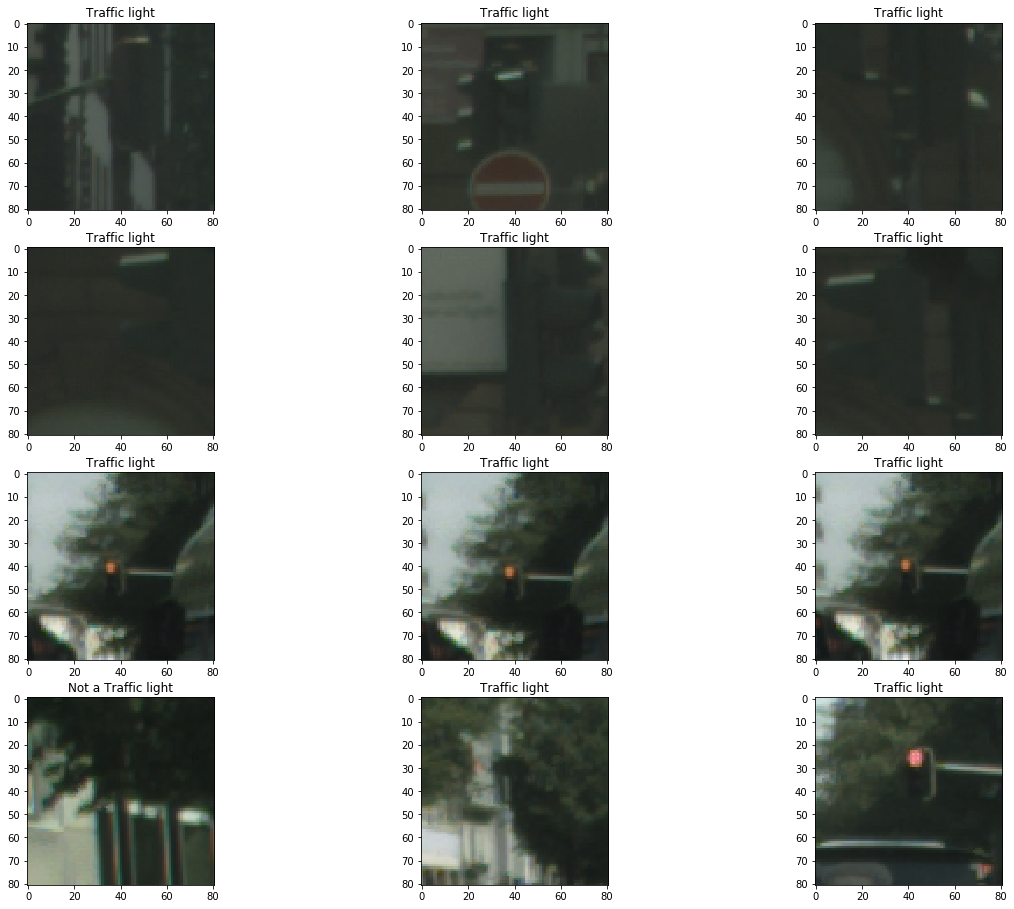

In [25]:
fig = plt.figure(figsize=(20,20))
  
j=0
rand=random.randint(0, 1809)

for i in range(rand, rand + 12):
    a = fig.add_subplot(5,3,j+1)
    j+=1
    a.imshow(data[i])
    a.title.set_text("Traffic light" if labels[i] else "Not a Traffic light");
plt.show()